In [11]:
!nvidia-smi

Sun Feb  2 17:46:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |   12416MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow scikit-learn
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dataset_path = '/content/drive/MyDrive/Raw_dataset'  # path to dataset
class_names = sorted(os.listdir(dataset_path))       # List of 17 classes
print("Class Names:", class_names)

Class Names: ['fight', 'give', 'hats_off', 'heart', 'hello', 'help', 'i_love_you', 'namaste', 'no', 'perfect', 'please', 'silent', 'sorry', 'stop', 'thank you', 'water', 'yes']


In [5]:
# Collect image paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        image_paths.append(img_path)
        labels.append(class_name)

# Encode labels to integers (0-16)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split into train (80%) and validation (20%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.2, random_state=42
)
print(f"Training Samples: {len(train_paths)}")
print(f"Validation Samples: {len(val_paths)}")

Training Samples: 5414
Validation Samples: 1354


In [6]:
def preprocess_train(image_path, label):
    # Read and decode image with explicit channels
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [480, 640])

    # Data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Normalize to [0, 1]
    image = image / 255.0
    return image, label

def preprocess_val(image_path, label):
    # Read and decode image (no augmentation)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(image, [480, 640])
    image = image / 255.0
    return image, label

In [7]:
batch_size = 16  # Reduce batch size if you run into GPU memory issues

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(480, 640, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Head
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(17, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 478, 638, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 239, 319, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 239, 319, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 237, 317, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 118, 158, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 118, 158, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 116, 156, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 58, 78, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 58, 78, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 76, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 38, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 38, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 272384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     139,461,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17)                  │           8,721 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 139,860,177 (533.52 MB)

 Trainable params: 139,859,217 (533.52 MB)

 Non-trainable params: 960 (3.75 KB)

In [9]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [10]:
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 2117s 6s/step - accuracy: 0.2628 - loss: 8.1421 - val_accuracy: 0.1773 - val_loss: 3.8895 - learning_rate: 1.0000e-04
Epoch 2/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 110s 323ms/step - accuracy: 0.5635 - loss: 2.9538 - val_accuracy: 0.7349 - val_loss: 2.3177 - learning_rate: 1.0000e-04
Epoch 3/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 121s 261ms/step - accuracy: 0.6880 - loss: 2.5217 - val_accuracy: 0.8944 - val_loss: 1.7733 - learning_rate: 1.0000e-04
Epoch 4/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 86s 254ms/step - accuracy: 0.7526 - loss: 2.2575 - val_accuracy: 0.8552 - val_loss: 1.8973 - learning_rate: 1.0000e-04
Epoch 5/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 142s 255ms/step - accuracy: 0.8006 - loss: 2.0720 - val_accuracy: 0.9217 - val_loss: 1.5849 - learning_rate: 1.0000e-04
Epoch 6/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 97s 287ms/step - accuracy: 0.8266 - loss: 1.9688 - val_accuracy: 0.8833 - val_loss: 1.7691 - learning_rate: 1.0000e-04
Epoch 7/50
339/339 ━━━━━━━━━━━━━━━━━━━━ 134s

In [13]:
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

model.save('/content/drive/MyDrive/scratch_cnn.h5')

85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 0.9941 - loss: 0.6181


Validation Accuracy: 99.26%


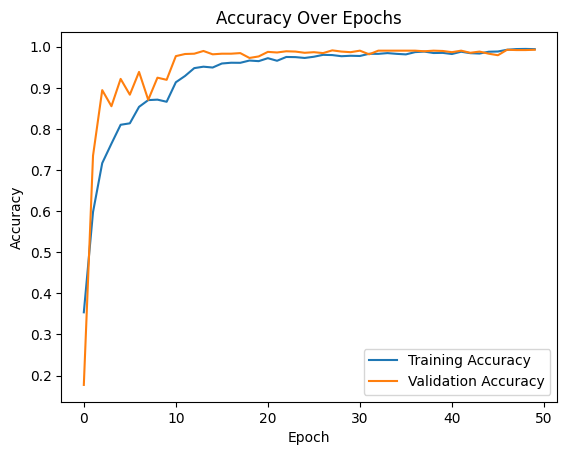

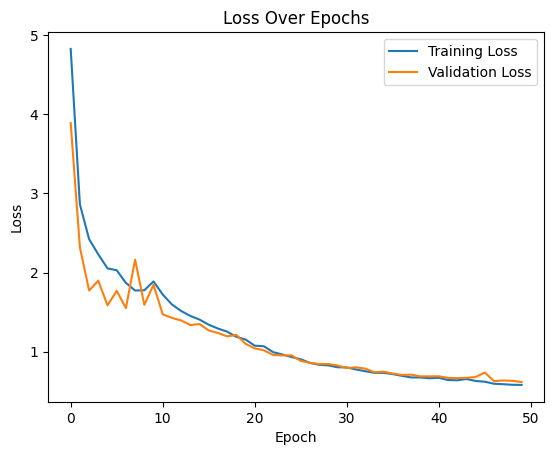

In [14]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
!nvidia-smi


Sun Feb  2 17:46:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |   12416MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----